<a href="https://colab.research.google.com/github/gwiederhecker/F429_notas/blob/master/2020_2s/aula6/load_data_aula_capacitor_detalha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd  # carregar arquivos e armazenar tabelas.
import matplotlib 
import matplotlib.pyplot as plt # pacote para graficar
import glob
import numpy as np
import os
from scipy.optimize import curve_fit

# Listando os arquivos no disco
Usaremos a wildcard ```'canais*.csv'``` para mostrar todos os arquivos com este padrão de nome

In [ ]:
# Esta célula só funcionará quem estiver com os arquivos no computador
path = '.' # ponto significa pasta atual
arquivos = 'canais*.csv'
busca =  os.path.join(path,arquivos) # une string de forma adequada ao seu OS
file_list = sorted(glob.glob(busca)) # lista os arquivo e ordena os resultados alfabeticamente 
pd.Series(file_list) # só para mostrar de forma amigável

0    ./canais_2020-11-09_17-18-49.csv
1    ./canais_2020-11-09_17-22-46.csv
dtype: object

In [5]:
#EXLUSIVO PARA GOOGLE COLAB, remover os símbolos de  comentários #:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/Colab Notebooks/F429/2020_2s/exemplo-aula-06/'
file_list = sorted(glob.glob(os.path.join(path,'*.csv')))
# res= pd.read_csv('resistores.csv')
print(pd.Series(file_list))

Mounted at /content/drive
0    drive/My Drive/Colab Notebooks/F429/2020_2s/ex...
dtype: object


In [6]:
file  = file_list[0] # pega o arquivo com este índice na lista de arquivos
data = pd.read_csv(file) # lê os resultados com o pacote PANDAS
data.head() # preve as primeiras linhas dos dados

,time(ms),voltage_0,voltage_1
0,0.000,0.159912,3.321533
1,0.026,0.117188,3.183594
2,0.052,0.080566,3.087158
3,0.078,0.062256,2.972412
4,0.104,0.062256,2.891846


# Plotando os resultados

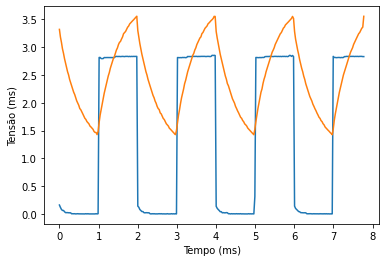

In [7]:
plt.plot(data['time(ms)'],data['voltage_0'])
plt.plot(data['time(ms)'],data['voltage_1'])
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão (ms)')
plt.show()

Para ver as estatísticas de cada canal, podemos utilizar os recursos do PANDAS

In [8]:
stat=data['voltage_1'].describe()
stat

count    300.000000
mean       2.451156
std        0.664158
min        1.425781
25%        1.833801
50%        2.424316
75%        3.054504
max        3.558350
Name: voltage_1, dtype: float64

Compare com os resultados do Numpy

In [9]:
print(stat['mean'])
print(stat['max'])
print(stat['min'])
print((stat['max']+stat['min'])/2)

2.4511556106666643
3.5583496
1.4257812
2.4920654


## Um pouco sobre médias e nível DC dos sinais medidos

Suponha que temos um sinal periódico arbitrário para ser medido com o Arduino. Este sinal pode ser escrito na forma, $$y_0(t)=y_0^{(dc)}+y_0^{(ac)}(t).$$
A parte com superscrito $^{(dc)}$ corresponde ao nível constante do sinal, que corresponde ao seu valor médio, já a parte com superscrito $^{(ac)}$ corresponde à parte oscilatória do mesmo.
Por exemplo, para obter estas duas componentes do sinal fazemos, $$ y_0^{(dc)}= <y_0> $$ e $$ y_0^{(ac)}(t)= y_0(t)-<y_0>,$$
sendo que o símbolo $<>$ denota a média temporal do sinal, ou, equivalentemente, seu valor médio.

Para uma função periódica qualquer $f(t)$, a média temporal é calculada como, $$<f>=\frac{1}{T}\int_{t_0}^{t_0+T}f(t)dt.$$
Quando amostramos o sinal com o Arduino, não temos mais uma função contínua, e sim um conjunto de pontos $\{f_i\}$ representando o valor da função nos instantes de tempo amostrados $\{t_i\}$. Se tivermos $N_T$ pontos amostrados em um **intervalo que corresponde a um período $T$**, a média temporal é dada por, $$<f>=\frac{1}{N}\sum_{i=i_0}^{N_T}f_i.$$ Sendo que $i_0$ corresponde ao índice do vetor de tempo $\{t_i\}$ associado ao instante de tempo $t_0$.

Uma pergunta pertinente é: como definir o período do vetor de dados para que a soma acima possa ser calculada corretamente? 
Existem algumas maneiras de se fazer isto, sendo que a mais geral é através da transformada de Fourier. Na célula seguinte demonstramos como fazer isto no Python utilizando o pacote SciPy através da transformada rápida de Fourier (*FFT - Fast Fourier Transform*) 

In [10]:
from scipy import fft # importa pacota de fft

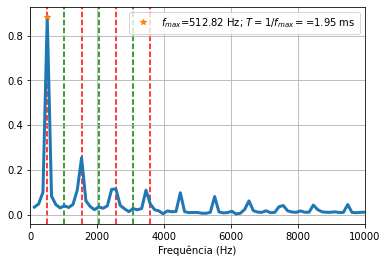

In [11]:
#***************************************
#1)Gerando a vetor de frequências para FFT
dt = (data['time(ms)'].iloc[1]-data['time(ms)'].iloc[0]) # intervalo de amostragem temporal
dt = 1e-3*dt # convertendo para segundos
Npt = len(data) # número total de pontos amostrados, não é o N_T acima!
freq = fft.fftfreq(Npt,dt) # gera o vetor de frequências para a FFT
freq = fft.fftshift(freq) # desloca a origem do vetor de frequências
#***************************************
#2)Calculando FFT
y = data['voltage_0'].values # atribui ao vetor y o
yf = 1/Npt*fft.fft(y) # calcula FFT
yf = fft.fftshift(yf) # desloca o vetor para corresponder às frequências corretas
Yf = np.abs(yf)
#***************************************
#3) Descartando frequências negativas, não nos interessam para este propósito
mask = freq>0 # mostrar apenas frequencias positivas
Yf = Yf[mask]
freq = freq[mask] 
#***************************************
#4) graficando o espectro de frequências (FFT) e identificando máxoimo
imax = np.argmax(Yf) # extrai o índice do vetor associado ao máximo do mesmo
fmax = freq[imax]
T = 1/fmax
plt.plot(freq,Yf,linewidth=3) # grafica magnitude da FFT
leg1 = '$f_{max}$' + '={:2.2f} Hz'.format(fmax)  # legenda, parte frequencia
leg2 = '$T=1/f_{max}=$' + '={:2.2f} ms'.format(1e3*T) # legenda, parte período
leg = leg1 + '; ' + leg2
plt.plot(freq[imax],Yf[imax],'*',label=leg) # coloca o ponto na posição do máximo
plt.xlim([0,1e4])
#----marcando a posição dos harmônicos, pares e ímpares
#harmonicos ímpares
for ordem in range(1,8,2):
    plt.axvline(ordem*fmax,linestyle='--',color='red',zorder=0)
#harmonicos pares
for ordem in range(2,8,2):
    plt.axvline(ordem*fmax,linestyle='--',color='green',zorder=0)
plt.grid()
plt.legend()
plt.xlabel('Frequência (Hz)')
plt.show()

<span style="color:red">Note que os diversos picos aparecem justamente no harmônicos da frequência fundamental (associado ao período do sinal), no caso os harmônicos ímpares $(f_0,3f_0,5f_0,...)$ são os mais importantes</span>.

Agora que foi encontrado com rigor o período do sinal, ```T=1/fmax```, é possível fazer a somatório com rigor, considerando apenas um período do sinal.
A seguir calculamos qual o intevalo de índices ```i_period``` que corresponde ao período do sinal calculado.

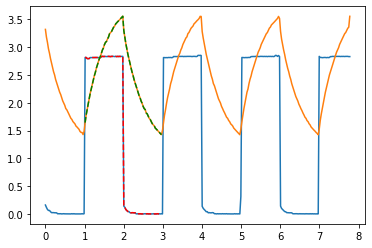

In [12]:
i_period = np.where(data['time(ms)']>T*1e3)[0][0] # descobre o índice do vetor de tempo que correponde a um período T
#i0: índice inicial, qualquer valor entre 0 e len(data['time(ms)']-i_period)
i0 = np.where(y>=1)[0][0] # pegando o ponto em que a o sinal sobe para valores maiores que 1 volt
#--
plt.plot(data['time(ms)'],data['voltage_0'])
plt.plot(data['time(ms)'].iloc[i0:i0+i_period],data['voltage_0'].iloc[i0:i0+i_period],'r--')
#--
plt.plot(data['time(ms)'],data['voltage_1'])
plt.plot(data['time(ms)'].iloc[i0:i0+i_period],data['voltage_1'].iloc[i0:i0+i_period],'g--')

É sobre os pontos  destacados em pontilhado acima que a média deve ser realizada:

In [13]:
print(data['voltage_0'].iloc[i0:i0+i_period].describe())
print(data['voltage_1'].iloc[i0:i0+i_period].describe())

count    76.000000
mean      1.420963
std       1.413414
min       0.000000
25%       0.003357
50%       1.467896
75%       2.832031
max       2.835693
Name: voltage_0, dtype: float64
count    76.000000
mean      2.488564
std       0.673369
min       1.427002
25%       1.878052
50%       2.492676
75%       3.091736
max       3.558350
Name: voltage_1, dtype: float64


Compare com a média feita sobre o vetor completo:

In [14]:
print(data['voltage_0'].describe())
print(data['voltage_1'].describe())

count    300.000000
mean       1.377022
std        1.406887
min        0.000000
25%        0.002441
50%        0.128174
75%        2.833252
max        2.855225
Name: voltage_0, dtype: float64
count    300.000000
mean       2.451156
std        0.664158
min        1.425781
25%        1.833801
50%        2.424316
75%        3.054504
max        3.558350
Name: voltage_1, dtype: float64


A diferença pode ser pequena, especialmente se amostrarmos um número grande de períodos, mas conceitualmente são bastante distintos. De fato, se não tomarmos cuidado em termos um número representativo de períodos, o resultado pode ser significativamente distinto.

## Recuperando o sinal "original" antes das alterações induzidas pelo nosso osciloscópio
No nosso osciloscópio, temos um filtro RC passa-altas na entrada (formado pelo capacitor de 1 $\mu$F e pelo resistor $R=\frac{470}{2}$ k$\Omega$ *PS: Você consegue perceber a razão do fator 2?*).
O efeito principal deste filtro passa-altas será remover o valor médio do sinal $y_1(t)$.  Isto significa que o sinal após o filtro (denotaremos pela símbolo $y_1^{(ac)}(t)$), será,
$$ y_1^{(ac)}(t)=y_1(t)-<y_1>.$$

Ou seja, apenas a componente "alternada" do sinal atravessa este filtro. Como alimentamos a dupla de resistores com $V_{DC}=5$V (formando um divisor de tensão), o sinal que a entrada A1 do Arduino irá medir será,
$$ v_1(t)=  y_1^{(ac)}(t)+\frac{V_{DC}}{2}\approx  y_1^{(ac)}(t)+ 2.5V.$$

In [15]:
i_period = np.where(data['time(ms)']>T*1e3)[0][0] # descobre o índice do vetor de tempo que correponde a um período T
i0 = np.where(y>=1)[0][0] # pegando o ponto em que a o sinal sobe para valores maiores que 1 volt
#-----------
mean0 = np.mean(data['voltage_0'].iloc[i0:i0+i_period]) # calculando a média do canal 1
mean1 = np.mean(data['voltage_1'].iloc[i0:i0+i_period]) # calculando a média do canal 1
data['y1_ac'] = data['voltage_1'] - mean1 #calculando a função g1(t) acima, após o filtro RC de entrada do osciloscópio

## Graficando estes sinais

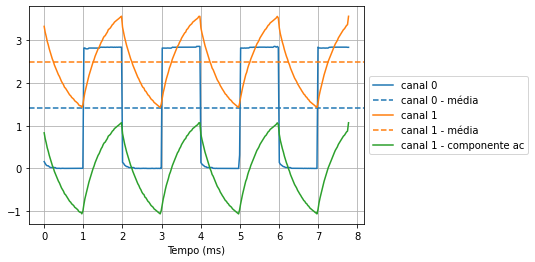

In [16]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # gera uma lista com a paleta de cores tradicional do matplotlib
#--
#canal 0
plt.plot(data['time(ms)'],data['voltage_0'],label='canal 0')
plt.axhline(mean0,ls='--',c=colors[0],label='canal 0 - média')
#--
#canal 1
plt.plot(data['time(ms)'],data['voltage_1'],label='canal 1')
plt.axhline(mean1,ls='--',c=colors[1],label='canal 1 - média')
#--
#componente AC do canal 1
plt.plot(data['time(ms)'],data['y1_ac'],label='canal 1 - componente ac')
#--
plt.xlabel('Tempo (ms)')
plt.grid()
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

Note que o sinal verde possui média zero!

Agora ainda resta uma pergunta: o sinal da saída do nosso circuito (chamado de $V_2(t)$ nos slides do roteiro) não é nenhum dos mostrados na figura acima!

Apesar disto, é possível recuperá-lo se nos lembrarmos da seguinte propriedades do circuitos RC excitados por sinais periódicos arbitrários:

1. Quando se mede a tensão sobre o **resistor** ($V_2(t)=Ri(t)$), o valor médio é sempre zero, i.e., $<V_2>=0$.

2. Quando se mede a tensão sobre o **capacitor** ($V_2(t)=q(t)/C$), o valor médio é idêntico ao valor médio do sinal de entrada, i.e., $<V_2>=<V_1>$.

<span style="color:red">*Você consegue perceber como estas duas propriedades são consequências diretas dos diagramas de Bode explorados no experimento anterior?*</span>.

Outra forma simples de pensar nisto é lembrar que estes circuitos RC ainda se comportamentam como divisores de tensão, mas que dependem da frequência do sinal. Contudo, o nível DC (ou tensão média) corresponde ao limite de frequência nula ($\omega\rightarrow 0$). Neste limite, a impedância do capacitor tende ao infinito ($Z_C=\frac{-j}{\omega C}$) e, portanto, toda a tensão média está concentrada neste componente. Portanto, quando medimos o resistor, detectamos tensão média nula e quando medimos o capacitor detectamos tensão média igual à tensão de entrada, respeitando o princípio da divisão de tensão.


In [17]:
data['y1'] = data['y1_ac'] +mean0  #pelos argumentos acima, recuparando o a sinal correspondente à tensão no capacitor

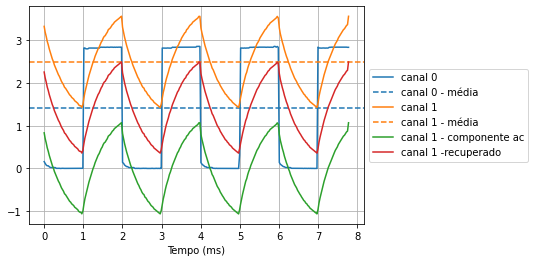

In [18]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # gera uma lista com a paleta de cores tradicional do matplotlib
#--
#canal 0
plt.plot(data['time(ms)'],data['voltage_0'],label='canal 0')
plt.axhline(mean0,ls='--',c=colors[0],label='canal 0 - média')
#--
#canal 1
plt.plot(data['time(ms)'],data['voltage_1'],label='canal 1')
plt.axhline(mean1,ls='--',c=colors[1],label='canal 1 - média')
#--
#componente AC do canal 1
plt.plot(data['time(ms)'],data['y1_ac'],label='canal 1 - componente ac')
#componente AC do canal 1
plt.plot(data['time(ms)'],data['y1'],label='canal 1 -recuperado')
#--
plt.xlabel('Tempo (ms)')
plt.grid()
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

<span style="color:red">As medidas no canal 1 acima foram tomadas sobre o capacitor. Partindo de medidas feitas sobre o  resistor, você conseguiria fazer um processo análogo e recuperar, a partir das medidas do nosso osciloscópio, a tensão em $V_2(t)=Ri(t)$ ?</span>.